In [1]:
from pathlib import Path
import tifffile
import napari
from apoc import PixelClassifier
from skimage import measure
import pandas as pd
import os
from skimage import io

In [2]:
# Define a function to get a list of filepaths for each image contained in a folder
def get_image_paths(folder_path):
    return [str(file_path) for file_path in folder_path.glob('*.tiff')]


def measure_biofilm (image_paths, save_directory):
    
    # Create an empty dictionary to store filename:biofilm_area pairs and later convert it into a pandas df
    biofilm_areas = {}

    # Initialize Napari viewer instance
    viewer = napari.Viewer(ndisplay=2)

    for filepath in image_paths:
        # Get the filename without the extension
        filename = Path(filepath).stem
        
        # Load one RGB image and extract the green channel for APOC
        rgb_img = tifffile.imread(filepath, is_ome = False)

        # Extract green channel [1]
        img = rgb_img[:,:,1]

        # Visualize greyscale green channel in napari
        viewer.add_image(img, name=f"Biofilm_{filename}")
        
        # Apply pretrained semantic segmenter from APOC
        semantic_segmenter = PixelClassifier(opencl_filename="./pretrained_classifiers/semantic_segmenter.cl")
        sem_seg_result = semantic_segmenter.predict(image=img)
        viewer.add_labels(sem_seg_result, name=f"Biofilm_layer_{filename}")
        
        # Store the resulting predictions
        tifffile.imwrite(os.path.join(save_directory, f"{filename}.tiff"),sem_seg_result)
        
        # Calculate the area covered by the biofilm
        props = measure.regionprops(sem_seg_result) # Calculate the background, biofilm and background crop area
        
        # Extract area values
        area_values = {"background": props[0].area, "biofilm": props[1].area, "crop_residue":props[2].area}
        
        # Testing purposes
        print(f"Filename: {filename}, Background: {props[0].area} pixels, Biofilm: {props[1].area} pixels, Plate: {(props[0].area + props[1].area)}")
        
        # Add new filename:biofilm_area pair to biofilm_areas
        biofilm_areas[filename] = [area_values]
        
    return biofilm_areas

In [3]:
# Define the directory containing your files
before_sonication_path = Path("./data/cropped/before_sonication_std/")
after_sonication_path = Path("./data/cropped/after_sonication_std/")

# Define the output folder path for the generated predictions
output_prediction_before = Path("./output/predictions/before_sonication_std")
output_prediction_after = Path("./output/predictions/after_sonication_std")

# Use the function to get the image paths
before_cropped_images = get_image_paths(before_sonication_path)
after_cropped_images = get_image_paths(after_sonication_path)

# Check if the output folders exist, create it if not
try:
    os.makedirs(output_prediction_before)
    print(f"Output folder created: {output_prediction_before}")
    os.makedirs(output_prediction_after)
    print(f"Output folder created: {output_prediction_after}")
except FileExistsError:
    print(f"Output folder already exists: {output_prediction_before}")
    print(f"Output folder already exists: {output_prediction_after}")

Output folder created: output\predictions\before_sonication_std
Output folder created: output\predictions\after_sonication_std


In [4]:
# Analyze the images and store the predictions
biofilm_areas_before = measure_biofilm(before_cropped_images, output_prediction_before)
biofilm_areas_after = measure_biofilm(after_cropped_images, output_prediction_after)

Filename: c_plate10_before, Background: 3267138.0 pixels, Biofilm: 1109752.0 pixels, Plate: 4376890.0
Filename: c_plate11_before, Background: 4120463.0 pixels, Biofilm: 246234.0 pixels, Plate: 4366697.0
Filename: c_plate12_before, Background: 3734441.0 pixels, Biofilm: 640743.0 pixels, Plate: 4375184.0
Filename: c_plate13_before, Background: 3853473.0 pixels, Biofilm: 511760.0 pixels, Plate: 4365233.0
Filename: c_plate14_before, Background: 3180710.0 pixels, Biofilm: 1187912.0 pixels, Plate: 4368622.0
Filename: c_plate15_before, Background: 3739527.0 pixels, Biofilm: 627562.0 pixels, Plate: 4367089.0
Filename: c_plate16_before, Background: 3996181.0 pixels, Biofilm: 367116.0 pixels, Plate: 4363297.0
Filename: c_plate17_before, Background: 3239101.0 pixels, Biofilm: 1129938.0 pixels, Plate: 4369039.0
Filename: c_plate18_before, Background: 4265721.0 pixels, Biofilm: 97607.0 pixels, Plate: 4363328.0
Filename: c_plate19_before, Background: 3874755.0 pixels, Biofilm: 491777.0 pixels, Plate

In [5]:
output_folder="./output/"

# Extract the data and create a DataFrame
data = []
for filename, values_list in biofilm_areas_before.items():
    values_dict = values_list[0]
    data.append({'filename': filename, **values_dict})

before_df = pd.DataFrame(data)

# Save the DataFrame to a CSV file in the output folder
before_df.to_csv(os.path.join(output_folder, 'biofilm_areas_before.csv'), index=False)

In [6]:
# Extract the data and create a DataFrame
data = []
for filename, values_list in biofilm_areas_after.items():
    values_dict = values_list[0]
    data.append({'filename': filename, **values_dict})

after_df = pd.DataFrame(data)

# Save the DataFrame to a CSV file in the output folder
after_df.to_csv(os.path.join(output_folder, 'biofilm_areas_after.csv'), index=False)

In [8]:
# Concatenate the DataFrames vertically
merged_df = pd.concat([before_df, after_df], ignore_index=True)

# Calculate plate area by adding background and biofilm
merged_df['plate_area'] = merged_df['background'] + merged_df['biofilm']

# Calculate the percentage of plate covered in biofilm
merged_df['biofilm_perc'] = (merged_df['biofilm']*100) / merged_df['plate_area']

# Reorder columns
merged_df = merged_df[['filename', 'background', 'biofilm', 'plate_area', 'biofilm_perc', 'crop_residue']]

# Extracting 'before' or 'after' and plate number
merged_df['condition'] = merged_df['filename'].str.extract(r'_(before|after)')
merged_df['plate_nr'] = merged_df['filename'].str.extract(r'plate(\d+)').astype(int)

# Save the DataFrame to a CSV file in the output folder
merged_df.to_csv(os.path.join(output_folder, 'biofilm_areas_final.csv'), index=False)

# Display the resulting DataFrame
merged_df

,filename,background,biofilm,plate_area,biofilm_perc,crop_residue,condition,plate_nr
0,c_plate10_before,3267138.0,1109752.0,4376890.0,25.354807,397271.0,before,10
1,c_plate11_before,4120463.0,246234.0,4366697.0,5.638907,193633.0,before,11
2,c_plate12_before,3734441.0,640743.0,4375184.0,14.644938,200101.0,before,12
3,c_plate13_before,3853473.0,511760.0,4365233.0,11.723544,753617.0,before,13
4,c_plate14_before,3180710.0,1187912.0,4368622.0,27.191915,453769.0,before,14
5,c_plate15_before,3739527.0,627562.0,4367089.0,14.370259,435527.0,before,15
6,c_plate16_before,3996181.0,367116.0,4363297.0,8.413729,222669.0,before,16
7,c_plate17_before,3239101.0,1129938.0,4369039.0,25.862392,296497.0,before,17
8,c_plate18_before,4265721.0,97607.0,4363328.0,2.236985,109833.0,before,18
9,c_plate19_before,3874755.0,491777.0,4366532.0,11.262416,153319.0,before,19


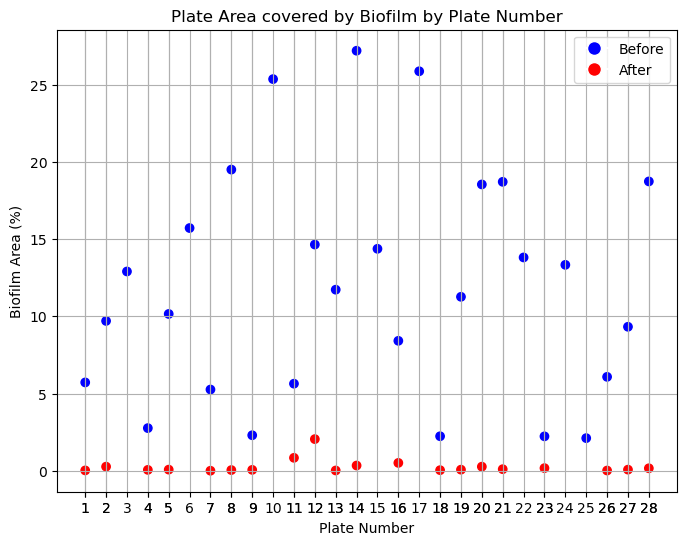

In [10]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(8, 6))
colors = {'before': 'blue', 'after': 'red'} # Assuming 'after' could be a condition as well
plt.scatter(merged_df['plate_nr'], merged_df['biofilm_perc'], c=merged_df['condition'].map(colors), label=['before', 'after'])

plt.title('Plate Area covered by Biofilm by Plate Number')
plt.xlabel('Plate Number')
plt.ylabel('Biofilm Area (%)')
plt.xticks(merged_df['plate_nr']) # Ensure all plate numbers are shown

# Create a legend for conditions
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='Before'),
                    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='After')])

plt.grid(True)
plt.show()